In [1]:
import ROOT
import numpy as np
import sys
import os

# sys.path.append('/home/rosedj1/HiggsMeasurement/CMSSW_10_2_15/src/HiggsMassMeasurement')
from PyUtils.fileUtils import makeDirs, copyFile
from PyUtils.tdrStyle import setTDRStyle

Welcome to JupyROOT 6.12/07


In [4]:
#FIXME: Eventually move these inside their own module.
def combine_cut_list(cut_list):
    total_cuts = ''
    for cut in cut_list:
        total_cuts += cut + ' && '
    cut_str = total_cuts.rstrip(' && ')
    return cut_str

def calc_num_bins(bin_min, bin_max, bin_width):
    return int(round( (bin_max-bin_min)/bin_width ))

def convert_cuts_to_title(cut_str, keep_whitespace=False):
    title = cut_str.replace(' && ','_')
    title = title.replace(' < ','_lt_')
    title = title.replace(' > ','_gt_')
    if not (keep_whitespace): 
        title = title.replace(' ','')
    title = title.replace('.','p')
    title = title.replace('(','')
    title = title.replace(')','')
    title = title.replace('-','neg')
    title = title.replace('+','pos')
    title = title.replace('||','or')
    title = title.replace('-13','muPlus')
    title = title.replace('+13','muMinus')
    return title

In [6]:
# %%capture
inpath_file_MC_2016 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2016.root'
inpath_file_MC_2017 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2017.root'
inpath_file_MC_2018 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2018.root'

#----- User Parameters -----#
run_over_all_ranges = 0
verbose = 1

make_plots_deltapT_dist = 1
make_plots_deltapT_vs_d0 = 1
save_plots_deltapTvsd0 = 1  # Just saves the deltapT vs. d0 plots. !!!FIXME!!! Get rid of this bool.

make_plots_mll_dist = 1
make_plots_mllmean_vs_d0 = 1

save_plots = 0  # Save canvases to Tier2 and make sure canvas looks fine.
save_plots_mllvsd0 = 1  # Just saves the mll vs. d0 plots. !!!FIXME!!! Get rid of this bool.

make_big_pdf = 1  # Run over range of d0, eta, or pT ranges. Combine into single PDF.

# make_plots_d0_dist = 0

year = "2016"  # MANUALLY CHANGE t_2016.Draw()!!!
charge = '+'  # Run over '-' (mu-) or '+' (mu+).
massZ_cut = ""
inpath_file = inpath_file_MC_2016
# inpath_file_list = [inpath_file_MC_2016,inpath_file_MC_2017,inpath_file_MC_2018]

# Out paths.
outpath_plots_deltapT_dist = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/deltapT_dist/" % year
outpath_plots_deltapT_vs_d0 = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/deltapT_vs_d0/" % year
outpath_plots_mll = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/mll_dist/" % year
outpath_plots_mll_vs_d0 = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/mll_mean_vs_d0/" % year

outpath_list = [
    outpath_plots_deltapT_dist,
    outpath_plots_deltapT_vs_d0,
    outpath_plots_mll,
    outpath_plots_mll_vs_d0,
]

d0_min = -0.005
d0_max = 0.002
d0_bin_width = 0.001

bs_or_pv = 'both'  # 'BS', 'PV', or 'both'

eta_arr = np.array([0.9, 1.8, 2.4])
# eta_arr = np.array([0.0, 0.8, 1.8, 2.4])

#---- deltapT/pT^2 distribution options. -----#
deltapT_min = -500  # GeV
deltapT_max = 500
deltapT_bin_width = 5  

#----- m_ll Z peak options. -----#
# plotname_d0_histo = "d0_PV_lead_mu"
# plotname_mll_fit = "mllfit_voigt_new"
# outpath_mll_fit_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/mll_fits/"
mll_x_min = 70
mll_x_max = 110
mll_bin_width = 0.2
fs = "2mu"
fit_n_stdev = 1  # Fit this many stdev around the mean. 

inpath_phpfile = '/home/rosedj1/'

#----------------------#
#----- Automatons -----#
#----------------------#
if year not in inpath_file:
    raise RuntimeError("Stopping now. Are you sure you are using the correct year?")
    
if len(eta_arr) <= 1:
    raise RuntimeError("Stopping now. You did not specify a valid eta range.")
    
if d0_min < -0.01 or d0_max > 0.01:
        raise RuntimeError("Stopping now. Are you sure you want such extreme d0_min or d0_max?")

if bs_or_pv in 'both':
    bspv_list = ['BS','PV']
elif bs_or_pv in ['BS','PV']:
    bspv_list = [bs_or_pv]
else:
    raise RuntimeError('Stopping now. Choose either "BS", "PV", or "both".')
    
if make_plots_mllmean_vs_d0 and not make_plots_mll_dist:
    raise RuntimeError("Stopping now. You need to turn on 'make_plots_mll_dist'!")

for outpath in outpath_list:
    copyFile(inpath_phpfile,'index.php',outpath)

if (run_over_all_ranges):    
    print "Running over full d0 and eta ranges.\n"
    d0_min = -0.010
    d0_max = 0.010
    d0_bin_width = 0.001
    eta_arr = np.array([0.0, 0.8, 1.8, 2.4])    
    deltapT_min = -500  # GeV
    deltapT_max = 500
    deltapT_bin_width = 5  

if (save_plots + make_big_pdf) > 1:
    err_msg = "Stopping now. Don't do both 'save_plots' and 'make_big_pdf' at the same time."
    raise RuntimeError(err_msg)
    
if charge in '-':
    ID = '13'
else: 
    ID = '-13'
# Includes all bin edges: very first to very last.
d0_bin_arr = np.arange(d0_min, d0_max+0.5*d0_bin_width, d0_bin_width)
d0_n_bins = calc_num_bins(d0_min, d0_max, d0_bin_width)
# Make sure points are plotted in middle of bin window.
d0_bin_arr_shifted = d0_bin_arr[0:-1] + 0.5*d0_bin_width
d0_bin_err = [d0_bin_width/2] * d0_n_bins  # Each "x-error" stretches half the width of the bin.
d0_bin_err_arr = np.array(d0_bin_err)

deltapT_n_bins = calc_num_bins(deltapT_min, deltapT_max, deltapT_bin_width)
mll_n_bins = calc_num_bins(mll_x_min, mll_x_max, mll_bin_width)

# setTDRStyle()
ROOT.gStyle.SetPadTickX(1);  # To get tick marks on the opposite side of the frame
ROOT.gStyle.SetPadTickY(1);

# hist_list = []
# graph_deltapT_list = []

f_2016 = ROOT.TFile.Open(inpath_file_MC_2016)
# f_2017 = ROOT.TFile.Open(inpath_file_MC_2017)
# f_2018 = ROOT.TFile.Open(inpath_file_MC_2018)

t_2016 = f_2016.Get("passedEvents")
# t_2017 = f_2017.Get("passedEvents")
# t_2018 = f_2018.Get("passedEvents")

graph_mll_bs_list = []
graph_mll_pv_list = []
graph_deltapT_bs_list = []
graph_deltapT_pv_list = []
#----------------#
#----- Main -----#
#----------------#
for num in xrange(len(eta_arr)-1):  # Don't use final element in array, since it has no next_eta. 
    this_eta = round(eta_arr[num], 1)  # Round to prevent float precision issues.
    next_eta = round(eta_arr[num+1], 1)
    this_eta_str = str(this_eta)
    next_eta_str = str(next_eta)

    for bspv in bspv_list:

        deltapT_mean_list = []
        deltapT_mean_err_list = []
        mll_mean_list = []
        mll_mean_err_list = []
        # This is the start of many, many plots.
        for d in xrange(len(d0_bin_arr)-1):  # Don't use final element in array, since it has no next_d0. 
            this_d0 = round(d0_bin_arr[d], 5)  # Should be able to round to 3, but use 5 for safety.
            next_d0 = round(d0_bin_arr[d+1], 5)
            this_d0_str = str(this_d0)
            next_d0_str = str(next_d0)

            #----- Plot the mll (Z peak) distribution. -----#
            if (make_plots_mll_dist):

                c_mll = ROOT.TCanvas()
                c_mll.cd()

                mll_cuts  = "(Id1 == %s && %s < d0%s1 && d0%s1 < %s && %s < eta1 && eta1 < %s) || " % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)
                mll_cuts += "(Id2 == %s && %s < d0%s2 && d0%s2 < %s && %s < eta2 && eta2 < %s)"     % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)

                mll_hist_name = "h_mll_mu%s_%s__%s_eta_%s__%s_d0_%s" % (charge, bspv, this_eta_str, next_eta_str, this_d0_str, next_d0_str)
                mll_hist_name = convert_cuts_to_title(mll_hist_name)
                h_mll = ROOT.TH1F(mll_hist_name, mll_cuts, mll_n_bins, mll_x_min, mll_x_max)
    #             h_mll_PV = ROOT.TH1F("h_mll", "muP_d0_PV", mll_n_bins, mll_x_min, mll_x_max)

                # @@@@@ WARNING: this is just for 2016 file!!! @@@@@
                t_2016.Draw("massZ >> %s" % mll_hist_name, mll_cuts, "")

                h_mll.GetXaxis().SetTitle("m_{#mu^{+}#mu^{-}} [GeV]")
                h_mll.GetYaxis().SetTitle("Events / [%.1f GeV]" % mll_bin_width)
                h_mll.GetXaxis().SetTitleOffset(1.3)
                h_mll.GetYaxis().SetTitleOffset(1.3)
                # h1.SetAxisRange(0.0, 0.1, "X")   
                # h1.SetLabelSize(0.03, "Y")                        
                # h1.SetLineColor(1)
                h_mll.Draw("hist 9 same")

                c_mll.Draw()
                # h1.Draw("e1 hist 9 same")
            
                if (save_plots):
#                     this_e = this_eta_str.replace('.','p')
#                     next_e = next_eta_str.replace('.','p')
#                     title = 'mll_d0%s_muPlus_MC%s_%s_eta_%s' % (bspv, year, e_min, e_max)
                    title = 'mll_dist_MC%s_mu%s__%s_eta_%s__%s_d0%s_%s' % (year, charge, this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                    title = convert_cuts_to_title(title)
                    fullpath = os.path.join(outpath_plots_mll, title)
                    c_mll.SaveAs(fullpath + '.png')
                    c_mll.SaveAs(fullpath + '.pdf')    

                if (make_big_pdf):
                    title = ("mll_dist_FullRun2_MC%s_mu%s__%s_eta_%s__%s_d0%s_%s_increm%s" % (year, 
                                                                                              charge,
                                                                                              str(this_eta),
                                                                                              str(next_eta),
                                                                                              str(d0_min),
                                                                                              str(bspv),
                                                                                              str(d0_max),
                                                                                              str(d0_bin_width))
                            )
                    title = convert_cuts_to_title(title)
                    fullpath = os.path.join(outpath_plots_mll, title)
                    if this_d0 == d0_min:
                        c_mll.Print(fullpath + '.pdf[')
                    c_mll.Print(fullpath + '.pdf')
                    if next_d0 == d0_max:
                        c_mll.Print(fullpath + '.pdf]')


                # Extract mean, RMS, and store for later.
                #--- FIXME! Implement a fit with CBxBW + exp
                #--- FIXME! Implement a fit with Voigtian
                if (make_plots_mllmean_vs_d0):
                    mean = h_mll.GetMean()
                    mean_err = h_mll.GetMeanError()
                    stdev = h_mll.GetStdDev()
                    stdev_err = h_mll.GetStdDevError()

                    mll_mean_list.append(mean)
                    mll_mean_err_list.append(mean_err)

                if (verbose):
                    print "mll_mean_list looks like:", mll_mean_list
                    print "mll_mean_err_list looks like:", mll_mean_err_list
                    print "Completed %s<eta<%s, %s<d0%s<%s \n" % (this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                
                
            #----- Plot the deltapT/pT2 distribution. -----#                
            if (make_plots_deltapT_dist):
                                   
                canv = ROOT.TCanvas()
                canv.cd()

                deltapT_cuts  = "(Id1 == %s && %s < d0%s1 && d0%s1 < %s && %s < eta1 && eta1 < %s) || " % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)
                deltapT_cuts += "(Id2 == %s && %s < d0%s2 && d0%s2 < %s && %s < eta2 && eta2 < %s)"     % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)

                deltapT_hist_name = "h_deltapT_mu%s_%s__%s_eta_%s__%s_d0_%s" % (charge, bspv, this_eta_str, next_eta_str, this_d0_str, next_d0_str)
                deltapT_hist_name = convert_cuts_to_title(deltapT_hist_name)  # Function isn't working?
                deltapT_hist_name = deltapT_hist_name.replace('+','pos') 
                deltapT_hist_name = deltapT_hist_name.replace('-','neg')

                h_deltapT = ROOT.TH1F(deltapT_hist_name, deltapT_cuts, deltapT_n_bins, deltapT_min, deltapT_max)

                # Fill up the histo with either lep1's deltapT info, if it has the ID of interest.
                # Otherwise use the other lep's deltapT info.
                tricky_root_expr  = "10000*(pT1-genLep_pt1)/genLep_pt1/genLep_pt1*(Id1==%s) + " % ID
                tricky_root_expr += "10000*(pT2-genLep_pt2)/genLep_pt2/genLep_pt2*(Id2==%s)" % ID
                
                # @@@@@ WARNING: this is just for 2016 file!!! @@@@@
                t_2016.Draw("%s >> %s"%(tricky_root_expr, deltapT_hist_name), deltapT_cuts, "")

                deltapT_dist_title = "10^{4} #times (p_{T}^{RECO}-p_{T}^{GEN})/(p_{T}^{GEN})^{2}"
                h_deltapT.GetXaxis().SetTitle(deltapT_dist_title)
                h_deltapT.GetYaxis().SetTitle("Events / [%.1f GeV^{-1}]" % deltapT_bin_width)
                h_deltapT.GetXaxis().SetTitleOffset(1.3)
                h_deltapT.GetYaxis().SetTitleOffset(1.3)
                # h1.SetAxisRange(0.0, 0.1, "X")   
                # h1.SetLabelSize(0.03, "Y")                        
                # h1.SetLineColor(1)
                h_deltapT.Draw("hist 9 same")

                canv.Draw()
                # h1.Draw("e1 hist 9 same")
            
                if (save_plots):
                    title = 'deltapT_dist_MC%s_mu%s__%s_eta_%s__%s_d0%s_%s' % (charge, year, this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                    title = convert_cuts_to_title(title)
                    fullpath = os.path.join(outpath_plots_deltapT_dist, title)
                    canv.SaveAs(fullpath + '.png')
                    canv.SaveAs(fullpath + '.pdf')    

                if (make_big_pdf):
                    pdf_title = ("deltapT_dist_FullRun2_MC%s_mu%s__%s_eta_%s__%s_d0%s_%s_increm%s" % (year, 
                                                                                              charge,
                                                                                              str(this_eta),
                                                                                              str(next_eta),
                                                                                              str(d0_min),
                                                                                              str(bspv),
                                                                                              str(d0_max),
                                                                                              str(d0_bin_width))
                            )
                    pdf_title = convert_cuts_to_title(pdf_title)
                    deltapT_dist_fullpath = os.path.join(outpath_plots_deltapT_dist, pdf_title)
                    if this_d0 == d0_min:
                        canv.Print(deltapT_dist_fullpath + '.pdf[')
                    canv.Print(deltapT_dist_fullpath + '.pdf')
                    if next_d0 == d0_max:
                        canv.Print(deltapT_dist_fullpath + '.pdf]')


                # Extract mean, RMS, and store for later.
                #--- FIXME! Implement a fit with CBxBW + exp
                #--- FIXME! Implement a fit with Voigtian
                if (make_plots_deltapT_vs_d0):
                    mean = h_deltapT.GetMean()
                    mean_err = h_deltapT.GetMeanError()
                    stdev = h_deltapT.GetStdDev()
                    stdev_err = h_deltapT.GetStdDevError()

                    deltapT_mean_list.append(mean)
                    deltapT_mean_err_list.append(mean_err)

                if (verbose):
                    print "deltapT_mean_list looks like:", deltapT_mean_list
                    print "deltapT_mean_err_list looks like:", deltapT_mean_err_list
                    print "Completed %s<eta<%s, %s<d0%s<%s \n" % (this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                

            
            # End of the first loop. Go to next d0 region.     

        # Finished all d0 regions. 
        
        if (make_plots_mllmean_vs_d0):
            # Convert everything to arrays, if not already one.
            mll_mean_arr = np.array(mll_mean_list)
            mll_mean_err_arr = np.array(mll_mean_err_list)

            if (verbose):
                print "d0_n_bins:",d0_n_bins
                print "len(d0_bin_arr_shifted):",len(d0_bin_arr_shifted)
                print "mll_mean_arr:",mll_mean_arr
                print "mll_mean_err_arr:",mll_mean_err_arr

            # Making a TGraphErrors for this BS/PV, eta region, d0_array.
            graph = ROOT.TGraphErrors(d0_n_bins, d0_bin_arr_shifted, mll_mean_arr, d0_bin_err_arr, mll_mean_err_arr)
            graph.this_eta = this_eta
            graph.next_eta = next_eta
            graph.color = 1 + num
            graph.bs_or_pv = bspv
            
            if graph.bs_or_pv in 'BS':
                graph_mll_bs_list.append(graph)
            else:
                graph_mll_pv_list.append(graph)
            # User may only select 'BS', so other list may be empty. 
    
        if (make_plots_deltapT_vs_d0):
            # Convert everything to arrays, if not already one.
            deltapT_mean_arr = np.array(deltapT_mean_list)
            deltapT_mean_err_arr = np.array(deltapT_mean_err_list)

            if (verbose):
                print "d0_n_bins:",d0_n_bins
                print "len(d0_bin_arr_shifted):",len(d0_bin_arr_shifted)
                print "deltapT_mean_arr:",deltapT_mean_arr
                print "deltapT_mean_err_arr:",deltapT_mean_err_arr

            # Making a TGraphErrors for this BS/PV, eta region, d0_array.
            graph = ROOT.TGraphErrors(d0_n_bins, d0_bin_arr_shifted, deltapT_mean_arr, d0_bin_err_arr, deltapT_mean_err_arr)
            graph.this_eta = this_eta
            graph.next_eta = next_eta
            graph.color = 1 + num
            graph.bs_or_pv = bspv
            
            if graph.bs_or_pv in 'BS':
                graph_deltapT_bs_list.append(graph)
            else:
                graph_deltapT_pv_list.append(graph)
            # User may only select 'BS', so other list may be empty. 
    
        # End of all d0 loops. Now switching from 'BS' to 'PV' (or vice versa).
        
# Eta regions are done. Make the plot with all eta regions.

#----- Make mllmean vs. d0 Plots. -----#
if (make_plots_mllmean_vs_d0):
    print ""
    y_min_mll = min(graph_mll_bs_list + graph_mll_pv_list)
    y_max_mll = max(graph_mll_bs_list + graph_mll_pv_list)

    for graph_list in [graph_mll_bs_list, graph_mll_pv_list]:
        if len(graph_list) == 0: continue
        count = 0
        leg_mll = ROOT.TLegend(0.75,0.8,0.9,0.9)                                           
        c_mllvsd0 = ROOT.TCanvas()
        c_mllvsd0.cd()
        c_mllvsd0.Draw()

        for gr in graph_list:
            gr.SetMarkerStyle(21)  # 5=X, 20=o, 21=square, 22=tri, 23=upside-down tri
            gr.SetMarkerColor(2 + count)  # 1=kBlack, 2=kRed, 3=kGreen, 4=kBlue
            gr.SetMinimum(87.0) 
            gr.SetMaximum(95.0)
            x_title = "d_{0}^{RECO, %s}(#mu^{%s}) [cm]" % (gr.bs_or_pv, charge)
    #         y_title = "mean m_{\\ell\\ell} \ [%.3f cm]" % (d0_bin_width)
            y_title = "mean m_{#mu#mu}" # / [%.3f cm]" % (d0_bin_width)
            gr.SetTitle( "mean m_{#mu#mu} vs. d_{0}^{%s}(#mu^{%s}) for %s MC" % (gr.bs_or_pv, charge, year) )
            gr.GetXaxis().SetTitle(x_title)
            gr.GetYaxis().SetTitle(y_title)
            gr.GetXaxis().SetTitleOffset(1.3)
        #     gr.GetYaxis().SetTitleOffset(1.3)

            gr.Draw("ap") if count == 0 else gr.Draw('p same')
        #     gr.Draw("apl") 

            leg_mll.AddEntry(gr,"%s < |#eta| < %s" % (str(gr.this_eta),str(gr.next_eta)),"lpe")  
        #     leg.AddEntry(h1,"%s < |#eta| < %s" % (str(this_eta),str(next_eta)),"lpf")                                                         
        #     leg.SetLineWidth(3)                                                       
        #     leg.SetBorderSize(0)                                                      
        #     leg.SetTextSize(0.03)    
            leg_mll.Draw("same")                                  
            count += 1

        if (save_plots_mllvsd0):
            e_min = str(min(eta_arr))
            e_max = str(max(eta_arr))
            title = 'meanmll_vs_d0%s_MC%s_mu%s_%s_eta_%s' % (graph_list[0].bs_or_pv, year, charge, e_min, e_max)
            title = convert_cuts_to_title(title)
            fullpath = os.path.join(outpath_plots_mll_vs_d0, title)
            c_mllvsd0.SaveAs(fullpath + '.png')
            c_mllvsd0.SaveAs(fullpath + '.pdf')     
            
            
#----- Make deltapT/pT^2 vs. d0 Plots. -----#            
if (make_plots_deltapT_vs_d0):
    y_min_deltapT = min(graph_deltapT_bs_list + graph_deltapT_pv_list)
    y_max_deltapT = max(graph_deltapT_bs_list + graph_deltapT_pv_list)

    for graph_list in [graph_deltapT_bs_list, graph_deltapT_pv_list]:
        if len(graph_list) == 0: continue
        count = 0
        leg_deltapT = ROOT.TLegend(0.75,0.8,0.9,0.9)                                           
        canv = ROOT.TCanvas()
        canv.cd()
        canv.Draw()

        for gr in graph_list:
            gr.SetMarkerStyle(21)  # 5=X, 20=o, 21=square, 22=tri, 23=upside-down tri
            gr.SetMarkerColor(2 + count)  # 1=kBlack, 2=kRed, 3=kGreen, 4=kBlue
            gr.SetMinimum(-100.0) 
            gr.SetMaximum(50.0)
            x_title = "d_{0}^{%s, RECO}(#mu^{%s}) [cm]" % (gr.bs_or_pv, charge)
    #         y_title = "mean m_{\\ell\\ell} \ [%.3f cm]" % (d0_bin_width)
            y_title = deltapT_dist_title # + "/ [%.3f cm]" % (d0_bin_width)
            gr.SetTitle( "#Deltap_{T}(#mu^{%s})/p_{T,GEN}^{2} vs. d_{0}^{%s}(#mu^{%s}) for %s MC" % (charge, gr.bs_or_pv, charge, year) )
            gr.GetXaxis().SetTitle(x_title)
            gr.GetYaxis().SetTitle(y_title)
            gr.GetXaxis().SetTitleOffset(1.3)
        #     gr.GetYaxis().SetTitleOffset(1.3)

            gr.Draw("ap") if count == 0 else gr.Draw('p same')
        #     gr.Draw("apl") 

            leg_deltapT.AddEntry(gr,"%s < |#eta| < %s" % (str(gr.this_eta),str(gr.next_eta)),"lpe")  
        #     leg.AddEntry(h1,"%s < |#eta| < %s" % (str(this_eta),str(next_eta)),"lpf")                                                         
        #     leg.SetLineWidth(3)                                                       
        #     leg.SetBorderSize(0)                                                      
        #     leg.SetTextSize(0.03)    
            leg_deltapT.Draw("same")                                  
            count += 1

        if (save_plots_deltapTvsd0):
            e_min = str(min(eta_arr))
            e_max = str(max(eta_arr))
            title = 'deltapT_vs_d0%s_MC%s_mu%s_%s_eta_%s' % (graph_list[0].bs_or_pv, year, charge, e_min, e_max)
            title = convert_cuts_to_title(title)
            fullpath = os.path.join(outpath_plots_deltapT_vs_d0, title)
            canv.SaveAs(fullpath + '.png')
            canv.SaveAs(fullpath + '.pdf')     

Info in <TCanvas::Print>: pdf file /home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/2016/Real_Run/mll_dist/mll_dist_FullRun2_MC2016_mupos__0p0_eta_0p8__neg0p01_d0BS_0p01_increm0p001.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file /home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/2016/Real_Run/mll_dist/mll_dist_FullRun2_MC2016_mupos__0p0_eta_0p8__neg0p01_d0BS_0p01_increm0p001.pdf
Info in <TCanvas::Print>: pdf file /home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/2016/Real_Run/deltapT_dist/deltapT_dist_FullRun2_MC2016_mupos__0p0_eta_0p8__neg0p01_d0BS_0p01_increm0p001.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file /home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/2016/Real_Run/deltapT_dist/deltapT_dist_FullRun2_MC2016_mupos__0p0_eta_0p8__neg0p01_d0BS_0p01_increm0p001.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file /home/rosedj1/public_html/H

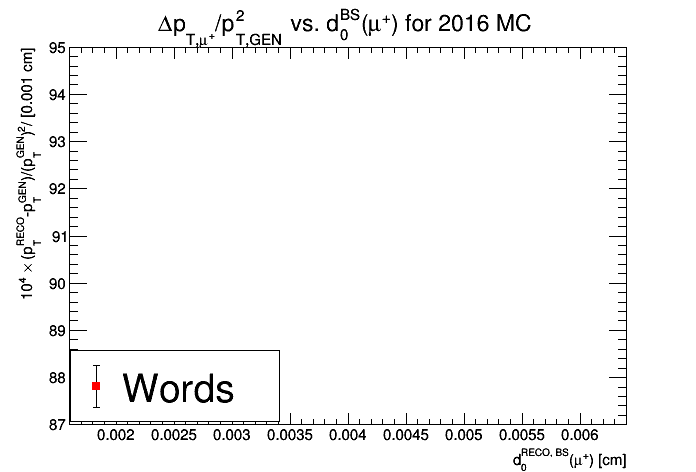

In [37]:
test_gr = graph_deltapT_bs_list[0]

c3 = ROOT.TCanvas()
c3.cd()

leg = ROOT.TLegend()
leg.AddEntry(test_gr, "Words", 'pe')
# test_gr.GetXaxis().SetTitleOffset(1.4)
test_gr.Draw()
leg.Draw('same')

c3.Draw()

test_gr.SetMinimum(-50.0)
test_gr.SetMaximum(50.0)
test_gr.Draw()
c3.Draw()

# Testing pT binning:

In [ ]:
# %%capture
inpath_file_MC_2016 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2016.root'
inpath_file_MC_2017 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2017.root'
inpath_file_MC_2018 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2018.root'

#----- User Parameters -----#
run_over_all_ranges = 1
verbose = 1

make_plots_deltapT_dist = 1
make_plots_d0_dist = 1
make_plots_deltapT_vs_d0 = 1

make_plots_mll_dist = 1
make_plots_mllmean_vs_d0 = 1

save_plots = 0  # Save canvases to Tier2 and make sure canvas looks fine.
save_plots_mllvsd0 = 1  # Just saves the mll vs. d0 plots. !!!FIXME!!! Get rid of this bool.
make_big_pdf = 1  # Run over range of d0, eta, or pT ranges. Combine into single PDF.

year = "2016"
use_pT_bins = 0
use_eta_bins = 1

inpath_file = inpath_file_MC_2016
# inpath_file_list = [inpath_file_MC_2016,inpath_file_MC_2017,inpath_file_MC_2018]

# Out paths.
outpath_plots_deltapT_dist = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/TEST/%s/deltapT_dist/TEST/" % year
outpath_plots_deltapT_vs_d0 = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/TEST/%s/deltapT_vs_d0/" % year
outpath_plots_mll = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/TEST/%s/mll_dist/" % year
outpath_plots_mll_vs_d0 = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/TEST/%s/mll_mean_vs_d0/" % year

outpath_list = [
    outpath_plots_deltapT_dist,
    outpath_plots_deltapT_vs_d0,
    outpath_plots_mll,
    outpath_plots_mll_vs_d0,
]

inpath_phpfile = '/home/rosedj1/'

d0_min = -0.007
d0_max = -0.004
d0_bin_width = 0.001

bs_or_pv = 'both'  # 'BS', 'PV', or 'both'

# eta_arr = np.array([0.0, 1.8, 2.2, 2.4])
eta_arr = np.array([0.0, 0.8, 1.8, 2.4])

#---- deltapT/pT^2 distribution options. -----#
deltapT_min = -500  # GeV
deltapT_max = 500
deltapT_bin_width = 5  

#----- m_ll Z peak options. -----#
# plotname_d0_histo = "d0_PV_lead_mu"
# plotname_mll_fit = "mllfit_voigt_new"
# outpath_mll_fit_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/mll_fits/"
mll_x_min = 70
mll_x_max = 110
mll_bin_width = 0.2
fs = "2mu"
fit_n_stdev = 1  # Fit this many stdev around the mean. 

#----------------------#
#----- Automatons -----#
#----------------------#
if year not in inpath_file:
    err_msg = "Stopping now. Are you sure you are using the correct year?"
    raise RuntimeError(err_msg)
    
for outpath in outpath_list:
    copyFile(inpath_phpfile,'index.php',outpath)

if (run_over_all_ranges):    
    print "Running over full d0 and eta ranges.\n"
    d0_min = -0.010
    d0_max = 0.010
    d0_bin_width = 0.001
    eta_arr = np.array([0.0, 0.8, 1.8, 2.4])    
    deltapT_min = -500  # GeV
    deltapT_max = 500
    deltapT_bin_width = 5  

if (save_plots + make_big_pdf) > 1:
    err_msg = "Stopping now. Don't do both 'save_plots' and 'make_big_pdf' at the same time."
    raise RuntimeError(err_msg)
    
if bs_or_pv in 'both':
    bspv_list = ['BS','PV']
elif bs_or_pv in ['BS','PV']:
    bspv_list = [bs_or_pv]
else:
    raise RuntimeError('Stopping now. Choose either "BS", "PV", or "both".')
    
if make_plots_mllmean_vs_d0 and not make_plots_mll_dist:
    raise RuntimeError("Stopping now. You need to turn on 'make_plots_mll_dist'!")

# Includes all bin edges: very first to very last.
d0_bin_arr = np.arange(d0_min, d0_max+0.5*d0_bin_width, d0_bin_width)
d0_n_bins = calc_num_bins(d0_min, d0_max, d0_bin_width)
# Make sure points are plotted in middle of bin window.
d0_bin_arr_shifted = d0_bin_arr[0:-1] + 0.5*d0_bin_width
d0_bin_err = [d0_bin_width/2] * d0_n_bins  # Each "x-error" stretches half the width of the bin.
d0_bin_err_arr = np.array(d0_bin_err)

# setTDRStyle()
ROOT.gStyle.SetPadTickX(1);  # To get tick marks on the opposite side of the frame
ROOT.gStyle.SetPadTickY(1);

hist_list = []
graph_deltapT_list = []

f_2016 = ROOT.TFile.Open(inpath_file_MC_2016)
# f_2017 = ROOT.TFile.Open(inpath_file_MC_2017)
# f_2018 = ROOT.TFile.Open(inpath_file_MC_2018)

t_2016 = f_2016.Get("passedEvents")
# t_2017 = f_2017.Get("passedEvents")
# t_2018 = f_2018.Get("passedEvents")


graph_mll_bs_list = []
graph_mll_pv_list = []
#----------------#
#----- Main -----#
#----------------#
for num in xrange(len(eta_arr)-1):  # Don't use final element in array, since it has no next_eta. 
    this_eta = round(eta_arr[num], 1)  # Round to prevent float precision issues.
    next_eta = round(eta_arr[num+1], 1)
    this_eta_str = str(this_eta)
    next_eta_str = str(next_eta)

    for num in xrange(len(eta_arr)-1):  # Don't use final element in array, since it has no next_eta. 
        this_eta = round(eta_arr[num], 1)  # Round to prevent float precision issues.
        next_eta = round(eta_arr[num+1], 1)
        this_eta_str = str(this_eta)
        next_eta_str = str(next_eta)

        for bspv in bspv_list:

            deltapT_mean_list = []
            deltapT_mean_err_list = []
            mll_mean_list = []
            mll_mean_err_list = []

            for d in xrange(len(d0_bin_arr)-1):  # Don't use final element in array, since it has no next_d0. 
                this_d0 = round(d0_bin_arr[d], 5)  # Should be able to round to 3, but use 5 for safety.
                next_d0 = round(d0_bin_arr[d+1], 5)
                this_d0_str = str(this_d0)
                next_d0_str = str(next_d0)

                if (verbose):
                    print "%.3f < d0 < %.3f" % (this_d0, next_d0)

                #----- Plot the mll (Z peak) distribution. -----#
                if (make_plots_mll_dist):

                    mll_n_bins = calc_num_bins(mll_x_min, mll_x_max, mll_bin_width)
                    c_mll = ROOT.TCanvas()
                    c_mll.cd()

                    # Synchronize with Xunwu by demanding that only mu+ satisfies d0 region.
                    mll_cuts  = "(Id1 == -13 && %s < d0%s1 && d0%s1 < %s && %s < eta1 && eta1 < %s) || " % (this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)
                    mll_cuts += "(Id2 == -13 && %s < d0%s2 && d0%s2 < %s && %s < eta2 && eta2 < %s)"     % (this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)

                    hist_name = "h_mll_%s__%s_eta_%s__%s_d0_%s_muPlus" % (bspv, this_eta_str, next_eta_str, this_d0_str, next_d0_str)
                    hist_name = convert_cuts_to_title(hist_name)
                    h_mll = ROOT.TH1F(hist_name, hist_name, mll_n_bins, mll_x_min, mll_x_max)
        #             h_mll_PV = ROOT.TH1F("h_mll", "muP_d0_PV", mll_n_bins, mll_x_min, mll_x_max)

                    # @@@@@ WARNING: this is just for 2016 file!!! @@@@@
                    t_2016.Draw("massZ >> %s" % hist_name, mll_cuts, "")

                    h_mll.GetXaxis().SetTitle("m_{l^{+}l^{-}} [GeV]")
                    h_mll.GetYaxis().SetTitle("Events / [%.1f GeV]" % mll_bin_width)
                    h_mll.GetXaxis().SetTitleOffset(1.3)
                    h_mll.GetYaxis().SetTitleOffset(1.3)
                    # h1.SetAxisRange(0.0, 0.1, "X")   
                    # h1.SetLabelSize(0.03, "Y")                        
                    # h1.SetLineColor(1)
                    h_mll.Draw("hist 9 same")

                    c_mll.Draw()
                    # h1.Draw("e1 hist 9 same")

                    if (save_plots):
    #                     this_e = this_eta_str.replace('.','p')
    #                     next_e = next_eta_str.replace('.','p')
    #                     title = 'mll_d0%s_muPlus_MC%s_%s_eta_%s' % (bspv, year, e_min, e_max)
                        title = 'mll_dist_muPlus_MC%s__%s_eta_%s__%s_d0%s_%s' % (year, this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                        title = convert_cuts_to_title(title)
                        fullpath = os.path.join(outpath_plots_mll, title)
                        c_mll.SaveAs(fullpath + '.png')
                        c_mll.SaveAs(fullpath + '.pdf')    

                    if (make_big_pdf):
                        title = ("mll_dist_muPlus_FullRun2_MC%s__%s_eta_%s__%s_d0%s_%s_increm%s" % (year, 
                                                                                              str(this_eta),
                                                                                              str(next_eta),
                                                                                              str(d0_min),
                                                                                              str(bspv),
                                                                                              str(d0_max),
                                                                                              str(d0_bin_width))
                                )
                        title = convert_cuts_to_title(title)
                        fullpath = os.path.join(outpath_plots_mll, title)
                        if this_d0 == d0_min:
                            c_mll.Print(fullpath + '.pdf[')
                        c_mll.Print(fullpath + '.pdf')
                        if next_d0 == d0_max:
                            c_mll.Print(fullpath + '.pdf]')


                    # Extract mean, RMS, and store for later.
                    #--- FIXME! Implement a fit with CBxBW + exp
                    #--- FIXME! Implement a fit with Voigtian
                    if (make_plots_mllmean_vs_d0):
                        mean = h_mll.GetMean()
                        mean_err = h_mll.GetMeanError()
                        stdev = h_mll.GetStdDev()
                        stdev_err = h_mll.GetStdDevError()

                        mll_mean_list.append(mean)
                        mll_mean_err_list.append(mean_err)

                    if (verbose):
                        print "mll_mean_list looks like:", mll_mean_list
                        print "mll_mean_err_list looks like:", mll_mean_err_list
                        print "Completed %s<eta<%s, %s<d0%s<%s" % (this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)

                # End of the first loop. Go to next d0 region. 

            # Finished all d0 regions. 
            print "Finished looping over d0 regions.\n"

            if (make_plots_mllmean_vs_d0):
                # Convert everything to arrays, if not already one.
                mll_mean_arr = np.array(mll_mean_list)
                mll_mean_err_arr = np.array(mll_mean_err_list)

                if (verbose):
                    print "d0_n_bins:",d0_n_bins
                    print "mll_mean_arr:",mll_mean_arr
                    print "mll_mean_err_arr:",mll_mean_err_arr
    #                 print "d0_bin_arr_shifted:",d0_bin_arr_shifted
    #                 print "len(d0_bin_arr_shifted):",len(d0_bin_arr_shifted)
    #                 print "d0_bin_err_arr:",d0_bin_err_arr

                # Making a TGraphErrors for this BS/PV, eta region, d0_array.
                graph = ROOT.TGraphErrors(d0_n_bins, d0_bin_arr_shifted, mll_mean_arr, d0_bin_err_arr, mll_mean_err_arr)
                graph.this_eta = this_eta
                graph.next_eta = next_eta
                graph.color = 1 + num
                graph.bs_or_pv = bspv
                print "This graph has graph.bs_or_pv =", graph.bs_or_pv

                if graph.bs_or_pv in 'BS':
                    graph_mll_bs_list.append(graph)
                    if (verbose): print "graph_mll_bs_list looks like:\n",graph_mll_bs_list
                else:
                    graph_mll_pv_list.append(graph)
                    if (verbose): print "graph_mll_pv_list looks like:\n",graph_mll_pv_list,"\n\n"
                # User may only select 'BS', so other list may be empty. 

            # End of all d0 loops. Now switching from 'BS' to 'PV' (or vice versa).

    # Eta regions are done. Make the plot with all eta regions.

    y_min = min(graph_mll_bs_list + graph_mll_pv_list)
    y_max = max(graph_mll_bs_list + graph_mll_pv_list)

    for graph_list in [graph_mll_bs_list, graph_mll_pv_list]:
        if len(graph_list) == 0: continue
        count = 0
        leg_mll = ROOT.TLegend(0.75,0.8,0.9,0.9)                                           
        c_mllvsd0 = ROOT.TCanvas()
        c_mllvsd0.cd()
        c_mllvsd0.Draw()

        for gr in graph_list:
            gr.SetMarkerStyle(21)  # 5=X, 20=o, 21=square, 22=tri, 23=upside-down tri
            gr.SetMarkerColor(2 + count)  # 1=kBlack, 2=kRed, 3=kGreen, 4=kBlue
            gr.SetMinimum(87.0) 
            gr.SetMaximum(95.0)
            x_title = "d0^{RECO}_{%s} [cm]" % (gr.bs_or_pv)
    #         y_title = "mean m_{\\ell\\ell} \ [%.3f cm]" % (d0_bin_width)
            y_title = "mean m_{#mu#mu} / [%.3f cm]" % (d0_bin_width)
            gr.SetTitle( "%s vs. d0_{%s} for %s MC" % (y_title, gr.bs_or_pv, year) ) 
            gr.GetXaxis().SetTitle(x_title)
            gr.GetYaxis().SetTitle(y_title)
            gr.GetXaxis().SetTitleOffset(1.3)
        #     gr.GetYaxis().SetTitleOffset(1.3)

            gr.Draw("ap") if count == 0 else gr.Draw('p same')
        #     gr.Draw("apl") 

            leg_mll.AddEntry(gr,"%s < |#eta| < %s" % (str(gr.this_eta),str(gr.next_eta)),"lpe")  
        #     leg.AddEntry(h1,"%s < |#eta| < %s" % (str(this_eta),str(next_eta)),"lpf")                                                         
        #     leg.SetLineWidth(3)                                                       
        #     leg.SetBorderSize(0)                                                      
        #     leg.SetTextSize(0.03)    
            leg_mll.Draw("same")                                  
            count += 1

        if (save_plots_mllvsd0):
            e_min = str(min(eta_arr))
            e_max = str(max(eta_arr))
            title = 'meanmll_vs_d0%s_MC%s_%s_eta_%s' % (graph_list[0].bs_or_pv, year, e_min, e_max)
            title = convert_cuts_to_title(title)
            fullpath = os.path.join(outpath_plots_mll_vs_d0, title)
            c_mllvsd0.SaveAs(fullpath + '.png')
            c_mllvsd0.SaveAs(fullpath + '.pdf')      

# Jake's Old Framework

In [ ]:
    x = ROOT.RooRealVar("x","x",fit_x_min,fit_x_max)
    l = ROOT.RooArgList(x)
    data = ROOT.RooDataHist("data", "MC massZ values", l, h_dude)

    w = ROOT.RooWorkspace()

    Voigt_sig_str = 'Voigtian::v(x[%s,%s], my_mean[%s,%s,%s], my_width[%s,%s,%s], my_sigma[%s,%s,%s])' % (str(fit_x_min),
                                                                                                          str(fit_x_max), 
                                                                                                          str(h_mean),
                                                                                                          str(hist_mll_x_min),
                                                                                                          str(hist_mll_x_max),
                                                                                                          str(h_stdev),
                                                                                                          str(0),
                                                                                                          str(fit_x_max),
                                                                                                          str(h_stdev),
                                                                                                          str(0),
                                                                                                          str(fit_x_max),)

    Exp_bkg_str = 'Exponential::e(x,tau[%s,%s,%s])' % (str(-0.5),
                                                      str(-5), 
                                                      str(0),)

    Model_sigbkg_str = 'SUM::model(s[%s,%s,%s]*v,b[%s,%s,%s]*e)' % (str(1E5),
                                                                    str(0),
                                                                    str(1E7),
                                                                    str(1E5),
                                                                    str(0),
                                                                    str(1E7),)

    w.factory(Voigt_sig_str)
    w.factory(Exp_bkg_str)
    w.factory(Model_sigbkg_str)


    # w.factory('Voigtian::v(x[86,96], my_mean[90,70,120], my_width[8,0,20], my_sigma[8,0,20])' % )
    # w.factory('Exponential::e(x,tau[-0.5,-5,0])')
    # w.factory('SUM::model(s[1E5,0,1E7]*v,b[1E5,0,1E7]*e)')
    pdf = w.pdf('model')
    w.Print()

    frame = x.frame()
    fit_result = pdf.fitTo(data,
                           ROOT.RooFit.Save(),
                           ROOT.RooFit.PrintLevel(-1)
                          )
    data.plotOn(frame)
    pdf.plotOn(frame)
    c = ROOT.TCanvas()
    frame.Draw()

    if (verbose): 
        print "Fit range [GeV] =",[fit_x_min,fit_x_max]
        fit_result.Print()

    mll_mean = w.var("my_mean").getVal()
    mll_mean_err = w.var("my_mean").getError()

In [ ]:
def fit_with_voigt(hist, n_stdev, draw=False, fit_around_center="mean", combine_bins=1):
    """
    fit_with_voigt(hist, n_stdev, draw=False, fit_around_center="mean", combine_bins=1)

    Fits a single histogram (hist) with a voigtian (Gauss conv. with BW) + exp-falling background.
        Fit range: mu +- n_stdev*sigma
            mu = mean of hist
            sigma = stdev of hist
            n_stdev = number of sigmas

    Fit can be done centered at the mean (fit_around_mean=True) or around the peak 
    of the histogram (fit_around_mean=False).

    Returns
    -------
    mll_mean : float
    mll_mean_err : float
    """
    hist_list_tmp = []
    fit_list = []
    canvas_list = []
    n_dof_list = []

    canvas_list.append(TCanvas())
    hist_list_tmp.append( hist.Clone() )
    h_tmp = hist_list_tmp[-1]
#     h_tmp.mass = mass
    # print "mass is:",mass
    # print "h_tmp.mass is:",h_tmp.mass
    # if rebin > 1: 
    #     h_tmp.Rebin(rebin)
    bin_width = h_tmp.GetBinWidth(1)  # Select bin next to underflow bin, for safety.
    h_tmp.bin_width = bin_width
    h_tmp.n_sigmas = nstdev
    h_tmp.mean = h_tmp.GetMean()
    h_tmp.stdev = h_tmp.GetStdDev()

    h_tmp.bin_at_max = h_tmp.GetMaximumBin()
    h_tmp.most_prob_val = h_tmp.GetXaxis().GetBinCenter(h_tmp.bin_at_max)

    if fit_around_center in "mean":
        center = h_tmp.mean
        center_str = "mean"
        print "Fitting around mean."
    elif fit_around_center in "mpv":
        # Fit around the peak instead.
        center = h_tmp.most_prob_val
        center_str = "most_prob_val"
        print "Fitting around mean."
    else: 
        raise SyntaxError("Warning: fit_around_center parameter not understood.")

    fit_x_min = center - nstdev*h_tmp.stdev
    fit_x_max = center + nstdev*h_tmp.stdev
    fit_list.append( TF1("fit1","gaus",fit_x_min,fit_x_max) )
    fit_tmp = fit_list[-1]

    # Do the fit.
    h_tmp.params = h_tmp.Fit(fit_tmp,"SRQ")  # S=store_result, R=ranged_fit, Q=quiet 

    # Get parameters.
    params = h_tmp.params

    h_tmp.fit_const = params.Parameter(0) 
    h_tmp.fit_const_err = params.ParError(0)
    h_tmp.fit_mean = params.Parameter(1)
    h_tmp.fit_mean_err = params.ParError(1)
    h_tmp.fit_sigma = params.Parameter(2)
    h_tmp.fit_sigma_err = params.ParError(2)            
    h_tmp.chi2 = fit_tmp.GetChisquare()  # This returns TOTAL chi^2, not reduced!
    h_tmp.n_dof = fit_tmp.GetNDF()

    # Since I'm storing each h_tmp in a hist_fit_list, 
    # I probably don't need these lists below.
    # FIXME: which values do I want to save? 
    #     - the main histogram (self)?
    #     - the h_tmp, of which there will be many? <-- probably this one?
    #     - lists of all the individual variables (listed below)
    fit_const_list.append( h_tmp.fit_const )
    fit_const_err_list.append( h_tmp.fit_const_err )
    fit_mean_list.append( h_tmp.fit_mean )
    fit_mean_err_list.append( h_tmp.fit_mean_err ) 
    fit_sigma_list.append( h_tmp.fit_sigma )
    fit_sigma_err_list.append( h_tmp.fit_sigma_err )
    fit_rel_sigma_list.append( h_tmp.fit_sigma/float(h_tmp.mass) )
    fit_rel_sigma_err_list.append( h_tmp.fit_sigma_err/float(h_tmp.mass) )
    n_dof_list.append( h_tmp.n_dof )

    try:
        h_tmp.reduced_chi2 = h_tmp.chi2/float(h_tmp.n_dof)
    except ZeroDivisionError:
        h_tmp.reduced_chi2 = np.inf
    red_chi2_list.append( h_tmp.reduced_chi2 )

    if not (draw):
        gROOT.SetBatch(kTRUE)  # Prevent ROOT from drawing plots to screen.
    gStyle.SetOptFit(1111)
#             gStyle.SetStatX(-0.1)
#             gStyle.SetStatY
    h_tmp.SetXTitle("m_{X} [GeV]")
    h_tmp.SetYTitle( "Events / [%.3f GeV]" % h_tmp.bin_width )

    extra_title = "Fit range: [%s #pm %.2f*sigma]" % (center_str,nstdev)
    if h_tmp.GetName() in ["mZ2_4e","mZ2_2mu2e"]:
        h_tmp.SetTitle("X #rightarrow e^{-}e^{+}, " + extra_title)
    else:
        h_tmp.SetTitle("X #rightarrow #mu^{-}#mu^{+}, " + extra_title)

    h_tmp.Draw('hist e1')
    fit_tmp.Draw("same")
    canvas_list[-1].Update()
    canvas_list[-1].Draw()
    # Done with fit.

    # Save all info in object.
    hist_fit_list = hist_list_tmp
    fit_list = fit_list
    canvas_list = canvas_list
    n_stdev_list = n_stdev_list

    return mll_mean, mll_mean_err

# Hualin-Style Old Stuff

In [ ]:
import os, sys, shutil, string, re
import numpy as np

import ROOT
from ROOT import (TFile,TTree,TH1D,TCanvas,TGraphErrors,TSelector,TF1,TLatex,
                  kTRUE,kDashed,
                  gPad,gStyle,gROOT,gDirectory,
                  RooFit,RooRealVar,RooVoigtian,RooExponential,RooAddPdf,RooFitResult,
                  RooMsgService,RooDataSet,RooDataHist,RooWorkspace,RooArgSet,RooArgList)
from subprocess import call
from array import array

RooMsgService.instance().setStreamStatus(1,False);

# sys.path.append('/home/rosedj1/HiggsMeasurement/')
# sys.path.append('/home/rosedj1/HiggsMeasurement/CMSSW_8_0_32/src/PyUtils/')

In [ ]:
class MllHistFit:
    def __init__(self,
                 fs,
                 d0_range,
                 inpath_file,
                 inpath_selector,
                 outpath,
                 massZ_lo,
                 massZ_hi,
                 bin_width,
                 n_bins_ZErr,
                 extra_cuts="",
                 make_new_selector=False
                 ): 
        """
        
        Create a histogram to be manipulated using user-defined methods.
        
        Parameters:
        -----------
        fs : str
            Final state.
        d0_range : array_like
            [initial_d0, final_d0]
        inpath_file : str
            Input file path.
        inpath_selector : str
            Input file path of selector, excluding file itself.
        outpath : str
            Output file path.
        massZ_lo : float
            Lower-bound of mll plot.
        massZ_hi : float
            Upper-bound of mll plot.
        bin_width : float
            Bin width for all bins.
        n_bins_ZErr : int
            Number of bins to use in ZErr analysis.
        extra_cuts : string, optional
            Cuts to apply to each event. Default = "".
        make_new_selector : bool
            If false (default) will NOT make_new_selector MySelector(.C,.h) found in inpath_file
        
        Returns
        -------
        Nothing yet.
        """
        self.fs = fs
        self.d0_range = d0_range
        self.inpath_file = inpath_file
        self.outpath = outpath
        self.massZ_lo = massZ_lo
        self.massZ_hi = massZ_hi
        self.bin_width = bin_width
        self.n_bins_ZErr = n_bins_ZErr 
        
        self.n_bins = -1
        self.name = "Testy_boi"
        self.cuts = ""
        
        #----- Automatic stuff -----#
        d0_min = d0_range[0]
        d0_max = d0_range[1]
        self.n_bins = int(round( (massZ_hi-massZ_lo)/bin_width ))

        
        # Apply massZ cuts.
        self.cuts += "%s < massZ && massZ < %s && " % (str(massZ_lo), str(massZ_hi))
        
        # Apply d0 cuts.
        self.cuts += "%s < d0BS1 && d0BS1 < %s && " % (str(d0_min), str(d0_max))
        self.cuts += "%s < d0BS2 && d0BS2 < %s"    % (str(d0_min), str(d0_max))
        
        if extra_cuts not in "": 
            self.cuts += " && " + extra_cuts
        
        # Access file and tree info.
        self.file = TFile(inpath_file)
        self.tree = self.file.Get("passedEvents")
        print 'tree opened'
        
        # Make dataset objects and a histogram object to store data.
        self.Data_Zlls = RooDataSet()
        self.Data_Zlls_w = RooDataSet()
        self.Data_Zlls_binned = RooDataHist()

        self.w = RooWorkspace("w","workspace")
#         print "Workspace after initialization:\n",self.w.Print()
            
        # Holds the input and output of a PDF fit to a dataset.
        self.fit_result = RooFitResult() 
        
    #---------------------------------------------------------------------#
    def prepare_dataset(self):
        # I'm a little confused... I thought that RooRealVar massZ was defined here,
        # but instead Hualin defines it in the next method, "combine_pdfs"...
        # Maybe it doesn't matter.
        
        self.tree.Draw(">>myList", self.cuts, "entrylist")
        # I think SetEntryList has something to do with PROOF and parallel processing.
        entryList = gDirectory.Get("myList")
        self.tree.SetEntryList(entryList)
        
         # Make selector object.
#         cwd = os.environ['PWD']
        selector_path = inpath_selector
        selector_name = "MySelector"
        fullpath_selector = os.path.join(selector_path,selector_name+".C")
        if not os.path.exists(fullpath_selector) and (make_new_selector):
            print "Making new selector file:", 
            self.tree.MakeSelector(selector_name)
        self.selector = TSelector.GetSelector(fullpath_selector)
        
        # These methods are defined in MySelector.C and called here.
        self.selector.SetNumBins(self.n_bins)
        self.selector.SetNumBins_ZErr(self.n_bins_ZErr)
        self.selector.SetRange_massZ(self.massZ_lo, self.massZ_hi)
        self.selector.SetRange_massZErr(0, 999)
#         selector.SetLambda( int(self.doLambda1), self.Lambdas["lambda1"], self.Lambdas["lambda2"] )

#       These variables are from MySelector.h. Putting them here for easy reference. 
#         rv_weight   = new RooRealVar("weight","weight", 0.00001, 100);
#         rv_massZ    = new RooRealVar("massZ","massZ", massZ_lo, massZ_hi);
#         rv_massZErr = new RooRealVar("massZErr","massZErr", massZErr_lo, massZErr_hi);
#         rastmp      = new RooArgSet(*rv_massZ, *rv_massZErr, *rv_weight);
#         Data_Zlls   = new RooDataSet("Zlls","Zlls", *rastmp);
#         massZ = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
#         massZErr = RooRealVar("massZErr","massZErr", self.massZErr_lo, self.massZErr_hi)

#         for key,val in self.shapePara.items():
#             print key,":",val

        # This is the big boy: run the Process method.
        # Go event by event in the tree and grab everything defined in 
        # the Process() section of MySelector.C.
        self.tree.Process(self.selector)
        
        self.Data_Zlls = self.selector.Data_Zlls # Store the values in a RooDataSet called Data_Zlls
        # Use Data_Zlls dataset to make a new WEIGHTED dataset.
        self.Data_Zlls_w = RooDataSet(self.Data_Zlls.GetName(), self.Data_Zlls.GetTitle(), self.Data_Zlls, self.Data_Zlls.get(), "1", "weight")
        print "RooDataSet Data_Zlls_w after cuts has " + str(self.Data_Zlls_w.numEntries()) + " events.\n"
        print "Cuts applied:\n", self.cuts

#         self.Data_Zlls_binned = self.Data_Zlls_w.binnedClone()
        
#         return self.w, self.Data_Zlls_w
        
        
        #---------------------------------------------------------------------#
    def combine_pdfs(self):
        """
        Creates the different PDFs (Voigtian signal, Exp bkg) and combines them into a "model".
        """
        massZ    = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
        massZErr = RooRealVar("massZErr","massZErr", 0,-10,10)
        mean = RooRealVar("mean","#mu",0,-5,5)  # Gaus and BW share the same mean!
        gaus_sigma = RooRealVar("gaus_sigma","#sigma_{gaus}",0,-5,5)
#         bw_mean = RooRealVar("bw_mean","#mu_{BW}",0,999)
        bw_width = RooRealVar("bw_width","#Gamma_{BW}",0,-5,5)
#         BW = RooBreitWigner("BW","Breit Wigner theory", massZ, breitWignerMean,breitWignerGamma)
#         breitWignerMean   = RooRealVar("breitWignerMean", "m_{Z^{0}}", self.GENZ_mean)
#         breitWignerGamma  = RooRealVar("breitWignerGamma", "#Gamma", self.GENZ_width)
#         breitWignerGamma.setConstant(kTRUE)
#         breitWignerMean.setConstant(kTRUE)
        tau = RooRealVar("tau","#tau",-1,1)
#         coeff = RooRealVar("coeff","coeff",0,-5,5)
        nsig = RooRealVar("nsig","#signal events",10000,0.,100000);
        nbkg = RooRealVar("nbkg","#background events",10000,0.,100000);
        # voigtian = BWxGaussian: const char* name, const char* title, RooAbsReal& _x, RooAbsReal& _mean, RooAbsReal& _width, RooAbsReal& _sigma, Bool_t doFast = kFALSE
        voigt = RooVoigtian("sig","sig", massZ, mean, bw_width, gaus_sigma)  # I believe this does the convolution on its own.
        exp = RooExponential("bkg","bkg",massZ, tau)
        
        #pa2 = RooRealVar("pa2","pa2", 0.0098, -10,10)
        #p2 = RooFormulaVar("p2", "@1*@0+@2*@0*@0",RooArgList(massZ,pa1,pa2)) # may not be used
        
        model = RooAddPdf("model","sig_plus_bkg_model",RooArgList(voigt, exp), RooArgList(nsig,nbkg))
        getattr(self.w,'import')(model) # same as doing: object.attribute
        
#------------------------------------------------------------------------------#      
    def do_fit(self):
        print "Number of entries in workspace Dat_Zlls_w:", self.Data_Zlls_w.numEntries()
        if self.Data_Zlls_w.numEntries() < 5000:
            print "Using an UN-binned fit."
#             mZ = self.w.var("massZ")
#             pdf_sum = self.pdf("model")
#             frame = mZ.frame()
#             data = pdf.generate(RooArgSet(mZ))
#             data.plotOn(frame)
#             fitResult = pdf.fitTo(data,RooFit.Save(),RooFit.PrintLevel(-1))
#             pdf.plotOn(frame)
#             frame.Draw()
            self.fit_result = self.w.pdf("model").fitTo(self.Data_Zlls_w, 
                                                        RooFit.Save(kTRUE), 
                                                        RooFit.SumW2Error(kTRUE), 
                                                        RooFit.PrintLevel(-1), 
                                                        RooFit.Timer(kTRUE)
                                                        )
#         else: 
#             print "Using a binned fit."
#             self.rFit = self.w.pdf("model").fitTo(self.Data_Zlls_binned, 
#                                                   RooFit.Save(kTRUE), 
#                                                   RooFit.SumW2Error(kTRUE), 
#                                                   RooFit.PrintLevel(-1), 
#                                                   RooFit.Timer(kTRUE)
#                                                   )

#------------------------------------------------------------------------------#      
    def get_params_from_fit(self):
        pass
    
    def plot_fit(self, outpath, save_plots=False):
        # Make a plotting frame (essentially a canvas).
        title_offset = 1.3
        
        PmassZ = self.w.var("massZ").frame(RooFit.Bins(self.n_bins))
        PmassZ.GetXaxis().SetTitle("m_{l^{+}l^{-}} [GeV]")
#          PmassZ.GetXaxis().SetTitle("m_{\\ell\\ell}\\ [GeV]")
        PmassZ.GetXaxis().SetTitleOffset(title_offset)
        PmassZ.GetYaxis().SetTitleOffset(title_offset)
    
        # Add the data to the plot.
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w, kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1),
                                   )
        
        # Add a box with parameters values to the frame.
        self.w.pdf("model").paramOn(PmassZ, 
                                    RooFit.Layout(0.17, 0.47, 0.9), 
                                    RooFit.Format("NE", RooFit.FixedPrecision(4))
                                    )
        
#         PmassZ.getAttText().SetTextSize(0.03)

        # Retrieve chi^2 test on the massZ fit
        # Also return a list of floating parameters after fit
#         chi2 = PmassZ.chiSquare(self.fit_result.floatParsFinal().getSize())
#         dof =  self.fit_result.floatParsFinal().getSize()

        # Draw the bkg and signal models???
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.Components("bkg"), 
                                   RooFit.LineStyle(kDashed)
                                   )
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w,kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1) 
                                   )
        
        
#         ch = TCanvas("ch","ch",1000,800)
        ch = TCanvas()
        ch.cd()

        PmassZ.Draw("")

        latex = TLatex()
        latex.SetNDC()
#         latex.SetTextSize(0.55*ch.GetTopMargin())
#         latex.SetTextFont(42)
#         latex.SetTextAlign(11)

        # DrawLatex(xcoord, ycoord, "text")
#         latex.DrawLatex(0.70, 0.85, "#chi^{2}/DOF = %.3f" %(chi2/float(dof)))    
        latex.DrawLatex(0.70, 0.8, "mean = %.3f" %(self.w.var("mean").getVal()))
        latex.DrawLatex(0.70, 0.75, "#sigma_{gaus} = %.3f" %(self.w.var("gaus_sigma").getVal()))        
        latex.DrawLatex(0.70, 0.7, "BW width = %.3f" %(self.w.var("bw_width").getVal()))
        latex.DrawLatex(0.70, 0.65, "nsig = %d" %(self.w.var("nsig").getVal()))
        latex.DrawLatex(0.70, 0.60, "nbkg = %d" %(self.w.var("nbkg").getVal()))
        latex.DrawLatex(0.70, 0.55, "#tau = %.3f" %(self.w.var("tau").getVal()))

#         latex.DrawLatex(0.70, 0.65, "n = %.3f" %(self.w.var("n").getVal()))
#         latex.DrawLatex(0.75, 0.65, "pa1 = %.3f" %(self.w.var("pa1").getVal()))
#         latex.DrawLatex(0.75, 0.6, "pa2 = %.3f" %(self.w.var("pa2").getVal()))
#         latex.DrawLatex(0.75, 0.55, "#sigma_{CB} = %.3f" %(self.w.function("sigma").getVal()))

        if (save_plots):
            plot_name = os.path.join(outpath,self.name)
            ch.SaveAs(plot_name + '.png')
            ch.SaveAs(plot_name + '.pdf')

#         return PmassZ, chi2, dof, ch, latex

In [ ]:
mll_hist_fit_list = []
mll_hist_fit_list.append( MllHistFit(fs,
                                     d0_range_list,
                                     inpath_file,
                                     inpath_selector,
                                     outpath_mll_fit_plots,
                                     mll_x_min,
                                     mll_x_max,
                                     mll_bin_width,
                                     n_bins_ZErr,
                                     cuts,
                                     make_new_selector,) 
                        )

mll_plot1 = mll_hist_fit_list[-1]

# Play with histogram object.
mll_plot1.prepare_dataset()
mll_plot1.combine_pdfs()  # Hualin called this "MakeModel_getLambda".
# print "workspace before the fit:",mll_plot1.w.Print()
mll_plot1.do_fit()
# print "workspace after the fit:",mll_plot1.w.Print()
# # PmassZ, chi2, dof, ch, latex = mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)
mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)

### The next section came from an old Voigt.ipynb
Most likely it doesn't work out of the box, 
but some may be salvageable. 

In [ ]:
import os, sys, shutil, string, re
import numpy as np

from ROOT import (TFile,TTree,TH1D,TCanvas,TGraphErrors,TSelector,TF1,TLatex,
                  kTRUE,kDashed,
                  gPad,gStyle,gROOT,gDirectory,
                  RooFit,RooRealVar,RooVoigtian,RooExponential,RooAddPdf,RooFitResult,
                  RooMsgService,RooDataSet,RooDataHist,RooWorkspace,RooArgSet,RooArgList)
from subprocess import call
from array import array

RooMsgService.instance().setStreamStatus(1,False);

# sys.path.append('/home/rosedj1/HiggsMeasurement/')
# sys.path.append('/home/rosedj1/HiggsMeasurement/CMSSW_8_0_32/src/PyUtils/')

#---------------------------#
#----- User Parameters -----# 
#---------------------------#
plotname_d0_histo = "d0_PV_lead_mu"
# plotname_mll_fit = "mllfitgaus_no_d0_cuts"
plotname_mll_fit = "mllfit_voigt"

inpath_file = "/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/provad0_2mu.root"
inpath_selector = "/home/rosedj1/HiggsMeasurement/CMSSW_10_2_15/src/HiggsMassMeasurement/d0_Studies"

outpath_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/"
outpath_mll_fit_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/mll_fits/"
php_file = "/home/rosedj1/index.php"

make_new_selector = False
draw_plots = False # To the screen.
save_plots = True  # As pdf and png.

fs = "2mu"
d0_bin_width = 0.001
mll_bin_width = 0.2  #GeV

mll_x_min = 86  # GeV
mll_x_max = 96  # GeV

n_bins_ZErr = 100
cuts = ""
#cuts = "0 < abs(eta1) && abs(eta1) < 0.9 && 0 < abs(eta2) && abs(eta2) < 0.9"

# d0_range_list = list(np.arange(d0_min,d0_max*1.0000001,d0_bin_width))
d0_range_list = [0.0, 0.001]

mll_hist_fit_list = []

#--------------------------#
class MllHistFit:
    def __init__(self,
                 fs,
                 d0_range,
                 inpath_file,
                 inpath_selector,
                 outpath,
                 massZ_lo,
                 massZ_hi,
                 bin_width,
                 n_bins_ZErr,
                 extra_cuts="",
                 make_new_selector=False
                 ): 
        """
        
        Create a histogram to be manipulated using user-defined methods.
        
        Parameters:
        -----------
        fs : str
            Final state.
        d0_range : array_like
            [initial_d0, final_d0]
        inpath_file : str
            Input file path.
        inpath_selector : str
            Input file path of selector, excluding file itself.
        outpath : str
            Output file path.
        massZ_lo : float
            Lower-bound of mll plot.
        massZ_hi : float
            Upper-bound of mll plot.
        bin_width : float
            Bin width for all bins.
        n_bins_ZErr : int
            Number of bins to use in ZErr analysis.
        extra_cuts : string, optional
            Cuts to apply to each event. Default = "".
        make_new_selector : bool
            If false (default) will NOT make_new_selector MySelector(.C,.h) found in inpath_file
        
        Returns
        -------
        Nothing yet.
        """
        self.fs = fs
        self.d0_range = d0_range
        self.inpath_file = inpath_file
        self.outpath = outpath
        self.massZ_lo = massZ_lo
        self.massZ_hi = massZ_hi
        self.bin_width = bin_width
        self.n_bins_ZErr = n_bins_ZErr 
        
        self.n_bins = -1
        self.name = "Stupid_Plot_will_not_fit_right"
        self.cuts = ""
        
        #----- Automatic stuff -----#
        d0_min = d0_range[0]
        d0_max = d0_range[1]
        self.n_bins = int(round( (massZ_hi-massZ_lo)/bin_width ))

        
        # Apply massZ cuts.
        self.cuts += "%s < massZ && massZ < %s && " % (str(massZ_lo), str(massZ_hi))
        
        # Apply d0 cuts.
        self.cuts += "%s < d0BS1 && d0BS1 < %s && " % (str(d0_min), str(d0_max))
        self.cuts += "%s < d0BS2 && d0BS2 < %s"    % (str(d0_min), str(d0_max))
        
        if extra_cuts not in "": 
            self.cuts += " && " + extra_cuts
        
        # Access file and tree info.
        self.file = TFile(inpath_file)
        self.tree = self.file.Get("passedEvents")
        print 'tree opened'
        
        # Make dataset objects and a histogram object to store data.
        self.Data_Zlls = RooDataSet()
        self.Data_Zlls_w = RooDataSet()
        self.Data_Zlls_binned = RooDataHist()

        self.w = RooWorkspace("w","workspace")
#         print "Workspace after initialization:\n",self.w.Print()
            
        # Holds the input and output of a PDF fit to a dataset.
        self.fit_result = RooFitResult() 
        
    #---------------------------------------------------------------------#
    def prepare_dataset(self):
        # I'm a little confused... I thought that RooRealVar massZ was defined here,
        # but instead Hualin defines it in the next method, "combine_pdfs"...
        # Maybe it doesn't matter.
        
        self.tree.Draw(">>myList", self.cuts, "entrylist")
        # I think SetEntryList has something to do with PROOF and parallel processing.
        entryList = gDirectory.Get("myList")
        self.tree.SetEntryList(entryList)
        
         # Make selector object.
#         cwd = os.environ['PWD']
        selector_path = inpath_selector
        selector_name = "MySelector"
        fullpath_selector = os.path.join(selector_path,selector_name+".C")
        if not os.path.exists(fullpath_selector) and (make_new_selector):
            print "Making new selector file:", 
            self.tree.MakeSelector(selector_name)
        self.selector = TSelector.GetSelector(fullpath_selector)
        
        # These methods are defined in MySelector.C and called here.
        self.selector.SetNumBins(self.n_bins)
        self.selector.SetNumBins_ZErr(self.n_bins_ZErr)
        self.selector.SetRange_massZ(self.massZ_lo, self.massZ_hi)
        self.selector.SetRange_massZErr(0, 999)
#         selector.SetLambda( int(self.doLambda1), self.Lambdas["lambda1"], self.Lambdas["lambda2"] )

#       These variables are from MySelector.h. Putting them here for easy reference. 
#         rv_weight   = new RooRealVar("weight","weight", 0.00001, 100);
#         rv_massZ    = new RooRealVar("massZ","massZ", massZ_lo, massZ_hi);
#         rv_massZErr = new RooRealVar("massZErr","massZErr", massZErr_lo, massZErr_hi);
#         rastmp      = new RooArgSet(*rv_massZ, *rv_massZErr, *rv_weight);
#         Data_Zlls   = new RooDataSet("Zlls","Zlls", *rastmp);
#         massZ = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
#         massZErr = RooRealVar("massZErr","massZErr", self.massZErr_lo, self.massZErr_hi)

#         for key,val in self.shapePara.items():
#             print key,":",val

        # This is the big boy: run the Process method.
        # Go event by event in the tree and grab everything defined in 
        # the Process() section of MySelector.C.
        self.tree.Process(self.selector)
        
        self.Data_Zlls = self.selector.Data_Zlls # Store the values in a RooDataSet called Data_Zlls
        # Use Data_Zlls dataset to make a new WEIGHTED dataset.
        self.Data_Zlls_w = RooDataSet(self.Data_Zlls.GetName(), self.Data_Zlls.GetTitle(), self.Data_Zlls, self.Data_Zlls.get(), "1", "weight")
        print "RooDataSet Data_Zlls_w after cuts has " + str(self.Data_Zlls_w.numEntries()) + " events.\n"
        print "Cuts applied:\n", self.cuts

#         self.Data_Zlls_binned = self.Data_Zlls_w.binnedClone()
        
#         return self.w, self.Data_Zlls_w
        
        
        #---------------------------------------------------------------------#
    def combine_pdfs(self):
        """
        Creates the different PDFs (Voigtian signal, Exp bkg) and combines them into a "model".
        """
        massZ    = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
        massZErr = RooRealVar("massZErr","massZErr", 0,-10,10)
        mean = RooRealVar("mean","#mu",0,-5,5)  # Gaus and BW share the same mean!
        gaus_sigma = RooRealVar("gaus_sigma","#sigma_{gaus}",0,-5,5)
#         bw_mean = RooRealVar("bw_mean","#mu_{BW}",0,999)
        bw_width = RooRealVar("bw_width","#Gamma_{BW}",0,-5,5)
#         BW = RooBreitWigner("BW","Breit Wigner theory", massZ, breitWignerMean,breitWignerGamma)
#         breitWignerMean   = RooRealVar("breitWignerMean", "m_{Z^{0}}", self.GENZ_mean)
#         breitWignerGamma  = RooRealVar("breitWignerGamma", "#Gamma", self.GENZ_width)
#         breitWignerGamma.setConstant(kTRUE)
#         breitWignerMean.setConstant(kTRUE)
        tau = RooRealVar("tau","#tau",-1,1)
#         coeff = RooRealVar("coeff","coeff",0,-5,5)
        nsig = RooRealVar("nsig","#signal events",10000,0.,100000);
        nbkg = RooRealVar("nbkg","#background events",10000,0.,100000);
        # voigtian = BWxGaussian: const char* name, const char* title, RooAbsReal& _x, RooAbsReal& _mean, RooAbsReal& _width, RooAbsReal& _sigma, Bool_t doFast = kFALSE
        voigt = RooVoigtian("sig","sig", massZ, mean, bw_width, gaus_sigma)  # I believe this does the convolution on its own.
        exp = RooExponential("bkg","bkg",massZ, tau)
        
        #pa2 = RooRealVar("pa2","pa2", 0.0098, -10,10)
        #p2 = RooFormulaVar("p2", "@1*@0+@2*@0*@0",RooArgList(massZ,pa1,pa2)) # may not be used
        
        model = RooAddPdf("model","sig_plus_bkg_model",RooArgList(voigt, exp), RooArgList(nsig,nbkg))
        getattr(self.w,'import')(model) # same as doing: object.attribute
        
#------------------------------------------------------------------------------#      
    def do_fit(self):
        print "Number of entries in workspace Dat_Zlls_w:", self.Data_Zlls_w.numEntries()
        if self.Data_Zlls_w.numEntries() < 5000:
            print "Using an UN-binned fit."
#             mZ = self.w.var("massZ")
#             pdf_sum = self.pdf("model")
#             frame = mZ.frame()
#             data = pdf.generate(RooArgSet(mZ))
#             data.plotOn(frame)
#             fitResult = pdf.fitTo(data,RooFit.Save(),RooFit.PrintLevel(-1))
#             pdf.plotOn(frame)
#             frame.Draw()
            self.fit_result = self.w.pdf("model").fitTo(self.Data_Zlls_w, 
                                                        RooFit.Save(kTRUE), 
                                                        RooFit.SumW2Error(kTRUE), 
                                                        RooFit.PrintLevel(-1), 
                                                        RooFit.Timer(kTRUE)
                                                        )
#         else: 
#             print "Using a binned fit."
#             self.rFit = self.w.pdf("model").fitTo(self.Data_Zlls_binned, 
#                                                   RooFit.Save(kTRUE), 
#                                                   RooFit.SumW2Error(kTRUE), 
#                                                   RooFit.PrintLevel(-1), 
#                                                   RooFit.Timer(kTRUE)
#                                                   )

#------------------------------------------------------------------------------#      
    def get_params_from_fit(self):
        pass
    
    def plot_fit(self, outpath, save_plots=False):
        # Make a plotting frame (essentially a canvas).
        title_offset = 1.3
        
        PmassZ = self.w.var("massZ").frame(RooFit.Bins(self.n_bins))
        PmassZ.GetXaxis().SetTitle("m_{l^{+}l^{-}} [GeV]")
#          PmassZ.GetXaxis().SetTitle("m_{\\ell\\ell}\\ [GeV]")
        PmassZ.GetXaxis().SetTitleOffset(title_offset)
        PmassZ.GetYaxis().SetTitleOffset(title_offset)
    
        # Add the data to the plot.
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w, kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1),
                                   )
        
        # Add a box with parameters values to the frame.
        self.w.pdf("model").paramOn(PmassZ, 
                                    RooFit.Layout(0.17, 0.47, 0.9), 
                                    RooFit.Format("NE", RooFit.FixedPrecision(4))
                                    )
        
#         PmassZ.getAttText().SetTextSize(0.03)

        # Retrieve chi^2 test on the massZ fit
        # Also return a list of floating parameters after fit
#         chi2 = PmassZ.chiSquare(self.fit_result.floatParsFinal().getSize())
#         dof =  self.fit_result.floatParsFinal().getSize()

        # Draw the bkg and signal models???
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.Components("bkg"), 
                                   RooFit.LineStyle(kDashed)
                                   )
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w,kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1) 
                                   )
        
        
#         ch = TCanvas("ch","ch",1000,800)
        ch = TCanvas()
        ch.cd()

        if not (draw_plots): gROOT.SetBatch(kTRUE)
        PmassZ.Draw("")

        latex = TLatex()
        latex.SetNDC()
#         latex.SetTextSize(0.55*ch.GetTopMargin())
#         latex.SetTextFont(42)
#         latex.SetTextAlign(11)

        # DrawLatex(xcoord, ycoord, "text")
#         latex.DrawLatex(0.70, 0.85, "#chi^{2}/DOF = %.3f" %(chi2/float(dof)))    
        latex.DrawLatex(0.70, 0.8, "mean = %.3f" %(self.w.var("mean").getVal()))
        latex.DrawLatex(0.70, 0.75, "#sigma_{gaus} = %.3f" %(self.w.var("gaus_sigma").getVal()))        
        latex.DrawLatex(0.70, 0.7, "BW width = %.3f" %(self.w.var("bw_width").getVal()))
        latex.DrawLatex(0.70, 0.65, "nsig = %d" %(self.w.var("nsig").getVal()))
        latex.DrawLatex(0.70, 0.60, "nbkg = %d" %(self.w.var("nbkg").getVal()))
        latex.DrawLatex(0.70, 0.55, "#tau = %.3f" %(self.w.var("tau").getVal()))

#         latex.DrawLatex(0.70, 0.65, "n = %.3f" %(self.w.var("n").getVal()))
#         latex.DrawLatex(0.75, 0.65, "pa1 = %.3f" %(self.w.var("pa1").getVal()))
#         latex.DrawLatex(0.75, 0.6, "pa2 = %.3f" %(self.w.var("pa2").getVal()))
#         latex.DrawLatex(0.75, 0.55, "#sigma_{CB} = %.3f" %(self.w.function("sigma").getVal()))

        if (save_plots):
            plot_name = os.path.join(outpath,self.name)
            ch.SaveAs(plot_name + '.png')
            ch.SaveAs(plot_name + '.pdf')

#         return PmassZ, chi2, dof, ch, latex

#--------------------------------------------#
#----- Fit m_ll peak with voigtian+exp. -----#
#--------------------------------------------#
mll_hist_fit_list.append( MllHistFit(fs,
                                     d0_range_list,
                                     inpath_file,
                                     inpath_selector,
                                     outpath_mll_fit_plots,
                                     mll_x_min,
                                     mll_x_max,
                                     mll_bin_width,
                                     n_bins_ZErr,
                                     cuts,
                                     make_new_selector,) 
                        )

mll_plot1 = mll_hist_fit_list[-1]

# Play with histogram object.
mll_plot1.prepare_dataset()
mll_plot1.combine_pdfs()  # Hualin called this "MakeModel_getLambda".
# print "workspace before the fit:",mll_plot1.w.Print()
mll_plot1.do_fit()
# print "workspace after the fit:",mll_plot1.w.Print()
# # PmassZ, chi2, dof, ch, latex = mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)
mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)

In [ ]:
class MyHist:
    """
    Each MyHist object should be associated with only one histogram (hist). 
    The purpose of a MyHist is to create methods which can operate on the associated hist.
    
    After many hours, I have concluded that the tree.Draw("branch>>hist") method 
    cannot save hist persistently, i.e. return it via a function or save it in 
    something like self.my_hist. 
    
    So instead I will just save the drawn hist on a canvas and 
    all important information about the hist in a MyHist object.
    
    FUTURE_IMPLEMENTATION: 
     - Save the generated hist in a root file for later access.
    """
    
    def __init__(self, 
                 inpath_file, 
                 path_to_tree, 
                 x_min, 
                 x_max, 
                 bin_width, 
                 cut_list, 
                 branch, 
                 verbose=False,
                 draw_plots=False,
                 save_plots=False):        
        
        self.inpath_file = inpath_file
        self.path_to_tree = path_to_tree
        self.x_min = x_min
        self.x_max = x_max
        self.bin_width = bin_width
        self.cut_list = cut_list
        self.branch = branch
        
        self.n_bins = -1
        self.cut_str = ''
        self.canvas = None
        
        f = ROOT.TFile.Open(inpath_file)
        t = f.Get(path_to_tree)
        
        self.n_bins = int(round( (self.x_max - self.x_min)/self.bin_width ))

        # Apply cuts.
#         cut_massZ = "%s < massZ && massZ < %s" % (str(mll_x_min), str(mll_x_max))
        self.combine_cut_list()
#         if (verbose): 
#             print "Tree found."
#             print "hist created:", hist
#             print "cut_str:", self.cut_str
        
        c = ROOT.TCanvas()        
        c.cd()
        h1 = ROOT.TH1F("newhist","Z peak",self.n_bins, self.x_min, self.x_max)
#         t.Draw(self.branch + ">>newhist(%s,%s,%s)" % (self.n_bins, self.x_min, self.x_max), self.cut_str, "goff") 
        t.Draw(self.branch + ">>newhist", self.cut_str, "goff") 
#         self.hist = ROOT.gDirectory.Get("newhist")    # WON'T BE SAVED AT THE END! :-(

        if not (draw_plots):
            ROOT.gROOT.SetBatch(ROOT.kTRUE)
        h1.Draw("e1 hist 9 same")
#         c.Modified()
#         c.Update()
        c.Draw()

#----- FIXME: 
#----- Only when the code CRASHES will the plots show up...


        # Collect important hist data since hist can't be saved.
        self.h_mean = self.hist.GetMean()
        self.h_stdev = self.hist.GetStdDev()

    #     fit_x_min = h_mean - fit_n_stdev*h_stdev
    #     fit_x_max = h_mean + fit_n_stdev*h_stdev